In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import TensorDataset, DataLoader

In [29]:
# Using my GPU for faster execution 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [30]:
# Load and sort the training dataset by 'breath_id' and 'time_step'
df = pd.read_csv("data/train.csv")
df = df.sort_values(['breath_id', 'time_step'])

In [31]:
features = ['R', 'C', 'time_step', 'u_in', 'u_out']
# Group the data by breath_id to form sequences for LSTM input
grouped = df.groupby('breath_id')

In [32]:
###########################################
# Data Preparation: Grouping by Breath
###########################################

X_sequences = []
y_sequences = []
for breath_id, group in grouped:
    group = group.sort_values('time_step')
    X_sequences.append(group[features].values)
    y_sequences.append(group['pressure'].values)

# Convert lists to numpy arrays
X_sequences = np.array(X_sequences)  
y_sequences = np.array(y_sequences)
# Reshape targets to have an extra dimension for regression output
y_sequences = y_sequences.reshape(y_sequences.shape[0], y_sequences.shape[1], 1)

print("X_sequences shape:", X_sequences.shape)
print("y_sequences shape:", y_sequences.shape)

# Split into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)

# Convert numpy arrays to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

X_sequences shape: (75450, 80, 5)
y_sequences shape: (75450, 80, 1)


In [33]:
###########################################
# Create a PyTorch Dataset and DataLoader
###########################################

class BreathDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = BreathDataset(X_train_tensor, y_train_tensor)
val_dataset = BreathDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [34]:
###########################################
# Define the LSTM Model using PyTorch
###########################################

class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size1=64, hidden_size2=32, output_size=1, dropout=0.2):
        super(BiLSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size1, batch_first=True, bidirectional=True)
        self.dropout1 = nn.Dropout(dropout)
        self.lstm2 = nn.LSTM(hidden_size1 * 2, hidden_size2, batch_first=True, bidirectional=True)
        self.dropout2 = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size2 * 2, output_size)
    
    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.dropout1(out)
        out, _ = self.lstm2(out)
        out = self.dropout2(out)
        out = self.fc(out)
        return out

input_size = len(features)

In [35]:
###########################################
# Function to Train Model and Return Evaluation Metrics
###########################################
def train_bilstm(hidden_size1, hidden_size2, num_epochs=100, patience=10):
    model = BiLSTMModel(input_size=input_size, hidden_size1=hidden_size1, hidden_size2=hidden_size2).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    best_val_loss = float('inf')
    patience_counter = 0
    train_mae_history = []  # record training MAE per epoch
    
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        avg_train_loss = np.mean(train_losses)
        
        # Compute training MAE at the end of this epoch
        model.eval()
        train_preds = []
        train_truth = []
        with torch.no_grad():
            for X_batch, y_batch in train_loader:
                outputs = model(X_batch)
                train_preds.append(outputs.cpu().numpy())
                train_truth.append(y_batch.cpu().numpy())
        train_preds = np.concatenate(train_preds, axis=0)
        train_truth = np.concatenate(train_truth, axis=0)
        epoch_train_mae = mean_absolute_error(train_truth.flatten(), train_preds.flatten())
        train_mae_history.append(epoch_train_mae)
        
        model.eval()
        val_losses = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_losses.append(loss.item())
        avg_val_loss = np.mean(val_losses)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    # Load best model and evaluate on validation set
    model.load_state_dict(best_model_state)
    model.eval()
    all_preds = []
    all_truth = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            all_preds.append(outputs.cpu().numpy())
            all_truth.append(y_batch.cpu().numpy())
    y_val_pred = np.concatenate(all_preds, axis=0)
    y_val_true = np.concatenate(all_truth, axis=0)
    y_val_true_flat = y_val_true.flatten()
    y_val_pred_flat = y_val_pred.flatten()
    
    mae = mean_absolute_error(y_val_true_flat, y_val_pred_flat)
    mse = mean_squared_error(y_val_true_flat, y_val_pred_flat)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val_true_flat, y_val_pred_flat)
    
    return mae, mse, rmse, r2, train_mae_history

In [36]:
###########################################
# Sensitivity Analysis: Number of Neurons in the First LSTM Layer
###########################################
# these are the hidden_size1 values and set hidden_size2 as half of hidden_size1.
hidden_sizes = [50, 100, 150, 200, 250, 300]
results = []

for hs in hidden_sizes:
    hidden_size1 = hs
    hidden_size2 = hs // 2  # set hidden_size2 as half of hidden_size1
    mae, mse, rmse, r2, train_mae_history = train_bilstm(hidden_size1, hidden_size2, num_epochs=100, patience=10)
    results.append((hidden_size1, mae, mse, rmse, r2, train_mae_history))
    print(f"Hidden Size1: {hidden_size1}, MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

Hidden Size1: 50, MAE: 0.4902, MSE: 0.6158, RMSE: 0.7847, R2: 0.9906
Hidden Size1: 100, MAE: 0.3744, MSE: 0.3486, RMSE: 0.5904, R2: 0.9947
Hidden Size1: 150, MAE: 0.3707, MSE: 0.3584, RMSE: 0.5986, R2: 0.9945
Hidden Size1: 200, MAE: 0.4136, MSE: 0.4561, RMSE: 0.6753, R2: 0.9930
Hidden Size1: 250, MAE: 0.3070, MSE: 0.2620, RMSE: 0.5119, R2: 0.9960
Hidden Size1: 300, MAE: 0.2797, MSE: 0.2227, RMSE: 0.4719, R2: 0.9966


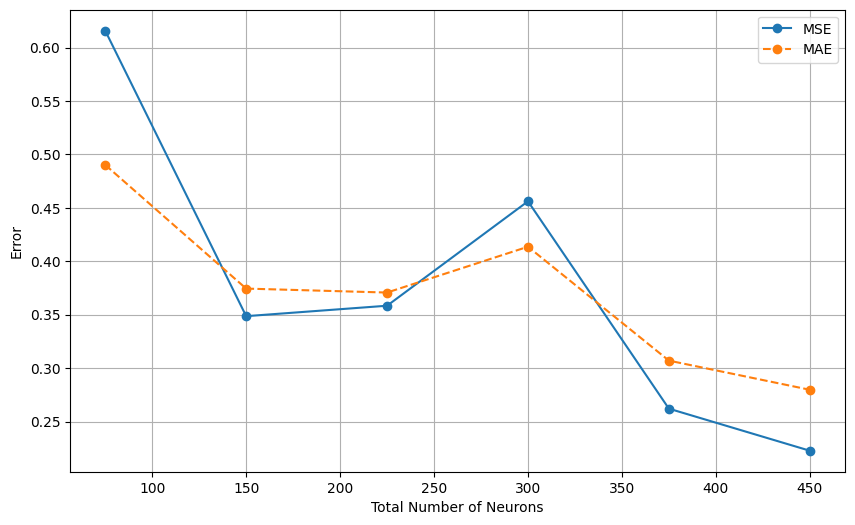

In [45]:
###########################################
# Plot Sensitivity Analysis: Total Neurons vs. Performance
###########################################

total_neurons = [int(hs + hs // 2) for hs, _, _, _, _, _ in results]
mse_values = [mse for _, _, mse, _, _, _ in results]
mae_values = [mae for _, mae, _, _, _, _ in results]

plt.figure(figsize=(10, 6))
plt.plot(total_neurons, mse_values, marker='o', linestyle='-', label='MSE')
plt.plot(total_neurons, mae_values, marker='o', linestyle='--', label='MAE')
plt.xlabel('Total Number of Neurons')
plt.ylabel('Error')
# plt.title('Sensitivity Analysis: Total Neurons vs. Performance')
plt.legend()
plt.grid(True)
plt.show()

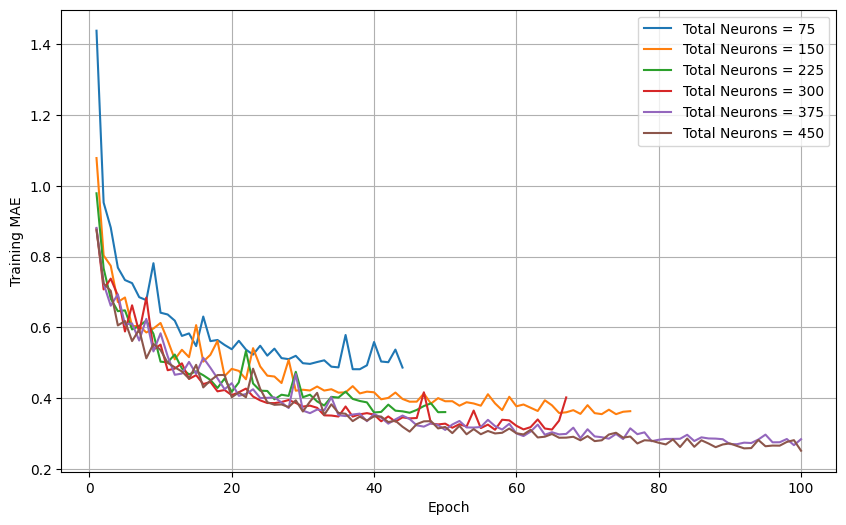

In [46]:
###########################################
#  Plot Training MAE vs. Epoch
###########################################
plt.figure(figsize=(10, 6))
for hs, _, _, _, _, train_mae_history in results:
    total_neurons = hs + (hs // 2)
    epochs = range(1, len(train_mae_history) + 1)
    plt.plot(epochs, train_mae_history,  linestyle='-', label=f"Total Neurons = {total_neurons}")
plt.xlabel('Epoch')
plt.ylabel('Training MAE')
# plt.title('Training MAE vs. Epoch for Different Total Neuron Sizes')
plt.legend()
plt.grid(True)
plt.show()